In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_rep = 100
n_bins = 1000
n_nodes = 10
n_regions = 40
n_reads = 10000
PATH = '../../workflows/bp_detection_performance/results/'

In [3]:
gt_files = [PATH + str(n_nodes)+'nodes_'+str(n_regions)+'regions_'+str(n_reads) \
             +'reads_simdata_'+str(x)+'_effective_regions.txt' for x in range(0,n_rep)]
bps_files = [PATH + 'simdata_'+str(x)+'_all_bps_comparison.csv' for x in range(0,n_rep)]
all_bins = range(0,n_bins)

In [15]:
all_bins

range(0, 1000)

In [35]:
all_tpr = []
all_fpr = []
for gt_file, bps_file in zip(gt_files, bps_files):
    bps = pd.read_csv(bps_file, header=None)
    bps.columns = ['idx','log_sp','stdev']
    bps['ranking'] = bps['log_sp'] / bps['stdev']
    # bps = bps.sort_values('ranking',ascending=False)
    bps = bps.dropna()
    ground_truth = pd.read_csv(gt_file,header=None)
    ground_truth = ground_truth[0].values.tolist()
    threshold_coeffs = sorted(bps['ranking'].values)
    # Each breakpoint candidate has a different stdev value.
    # The ROC computations takes that into account.tpr_values = []
    tpr_values = []
    fpr_values = []
    for thr in threshold_coeffs:
        predicted_positives = []
        predicted_negatives = []
        for index, row in bps.iterrows():
            if row['ranking'] > thr:
                predicted_positives.append(row['idx'])
            else:
                break 
                
        #import ipdb; ipdb.set_trace()
        predicted_negatives = [i for i in all_bins if i not in predicted_positives]

        true_positives = [i for i in predicted_positives if i in ground_truth]
        false_positives = [i for i in predicted_positives if i not in ground_truth]

        true_negatives = [i for i in predicted_negatives if i not in ground_truth]
        false_negatives = [i for i in predicted_negatives if i in ground_truth]

        # import ipdb; ipdb.set_trace()
        assert(len(ground_truth) == (len(true_positives) + len(false_negatives)))
        tpr = len(true_positives) / len(ground_truth) # len(ground_truth)
        fpr = len(false_positives) / (1000 - len(ground_truth)) # (len(false_positives) + len(true_negatives))
        tpr_values.append(tpr)
        fpr_values.append(fpr)
    
    all_tpr.append(tpr_values)
    all_fpr.append(fpr_values)

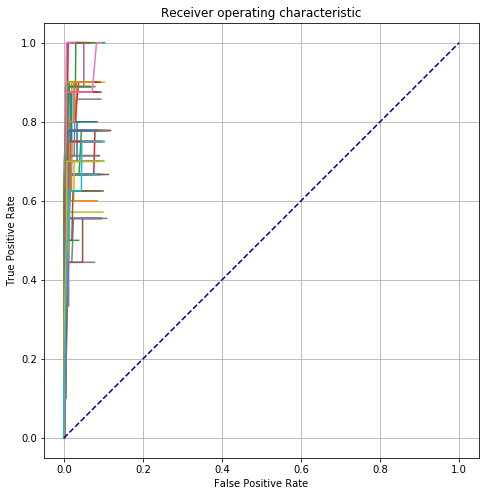

In [36]:
auc_vals = []
plt.figure(figsize=(8,8))
for tpr_values, fpr_values in zip(all_tpr, all_fpr):
    roc_auc = auc(fpr_values, tpr_values)
    auc_vals.append(roc_auc)
    plt.plot(fpr_values, tpr_values) # label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
plt.show()

In [22]:
pd.DataFrame(auc_vals, columns=['AUC']).describe()

,AUC
count,100.000000
mean,0.057471
std,0.016147
min,0.015808
25%,0.046684
50%,0.059670
75%,0.067477
max,0.096367
